# Running Canonical Monte Carlo Sampling

In [18]:
import numpy as np
import json
from pymatgen.core.structure import Structure
from smol.io import load_work
import os

### 0) Load the previous LNO CE with electrostatics

In [19]:
#work_path = '/Users/myless/Packages/structure_maker/Expansions/un_fixed_vcrtizrw_fin_work.mson'
#work_path = '/Users/myless/Packages/structure_maker/Expansions/single_prim_altered_struc_vcrtizrw_fin_work.mson'
work_path = '/Users/myless/Packages/structure_maker/Expansions/VCrTiWZr'
expansion_path = 'Zr0_109-Ti0_062-V0_611-Cr0_109-W0_109_fin_work.mson'
total_path = os.path.join(work_path,expansion_path)
work = load_work(total_path)
expansion = work['ClusterExpansion']

### 1) Create a canonical ensemble
The `Ensemble` class can be used to run MC in a fixed composition ensemble.
The ensemble classes will determine the **active** sublattices by grouping all sites that have the same possible partial occupancies.

To run for fixed chemical potential see the notebook on semigrand ensemble MC.

In [20]:
from smol.moca import Ensemble

# Create the ensemble
# This specifies the size of the MC simulation domain.
# this gives a 64 site unit cell
sc_matrix = np.array([
    [12, 0, 0],
    [0, 12, 0],
    [0, 0, 12]
])
"""
# 64 atom unit cell?
sc_matrix = np.array([
    [4, 1, 3],
    [2, 4, 1],
    [3, 2, 4]
])
"""

# this convenience method will take care of creating the appropriate
# processor for the given cluster expansion.
ensemble = Ensemble.from_cluster_expansion(expansion, sc_matrix)

# In a real scenario you may want a much larger processor.size
# An MC step is O(1) with the processor.size, meaning it runs at
# the same speed regardless of the size. However, larger sizes
# will need many more steps to reach equilibrium in an MC simulation.
print(f'The supercell size for the processor is {ensemble.processor.size} prims.')
print(f'The ensemble has a total of {ensemble.num_sites} sites.')
print(f'The active sublattices are:')
for sublattice in ensemble.sublattices:
    print(sublattice)

The supercell size for the processor is 1728 prims.
The ensemble has a total of 1728 sites.
The active sublattices are:
Sublattice(site_space=Zr0.109 Ti0.062 V0.611 Cr0.109 W0.109 , sites=array([   0,    1,    2, ..., 1725, 1726, 1727]), active_sites=array([   0,    1,    2, ..., 1725, 1726, 1727]), encoding=array([0, 1, 2, 3, 4]))


### 3) Create an MC sampler
A `Sampler` will take care of running MC sampling runs for a given ensemble. The sampler allows many different options for MC sampling most importantly setting the MCMC algorithm and the type of MC steps taken. However the defaults are usually enough for almost all use cases.

In [21]:
from smol.moca import Sampler

# This will take care of setting the defaults
# for the supplied canonical ensemble
# here we also set the temperature to our operating temperature, in V-Cr-Ti this should be around 900K 
T_sample = 973.15
sampler = Sampler.from_ensemble(ensemble, temperature=T_sample)
print(f"Sampling information: {sampler.samples.metadata}")

Sampling information: Metadata(cls_name='SampleContainer', kernels=[Metadata(seed=55880029059705808353038481910680709758, step=Metadata(sublattices=[(Element Zr, Element Ti, Element V, Element Cr, Element W)], sublattice_probabilities=array([1.]), cls_name='Swap'), cls_name='Metropolis')])


In [22]:
compositions = [sublattice.composition for sublattice in ensemble.sublattices]
print(compositions)


[Composition('Zr0.109 Ti0.062 V0.611 Cr0.109 W0.109')]


### 3) Create an initial structure and get occupancies
You will need to create an initial test structure to obtain an initial occupancy to start an MC run. There are many ways to do this, you could simply rescale a training structure and use that. But since the composition is fixed in a canonical ensemble you need to make sure you input the right composition. It can also be helpful to run a simulated anneal step to get a good initial structure rather than starting with a low energy one.

Here we will use the underlying processor to generate a random occupancy at the composition of the disordered structure used in the original cluster expansion

In [23]:
from smol.capp.generate import generate_random_ordered_occupancy

compositions = [sublattice.composition for sublattice in ensemble.sublattices]
init_occu = generate_random_ordered_occupancy(ensemble.processor, composition=compositions,tol = 0.5)

print(f"The disordered structure has composition: {ensemble.processor.structure.composition}")
print(f"The initial occupancy has composition: {ensemble.processor.structure_from_occupancy(init_occu).composition}")

The disordered structure has composition: Zr188.352 Ti107.136 V1055.808 Cr188.352 W188.352
The initial occupancy has composition: V1056 Cr188 Zr189 Ti107 W188


In [24]:
# The occupancy strings created by the processor
# are by default "encoded" by the indices of the species
# for each given site. You can always see the actual
# species in the occupancy string by decoding it.
print(f'The encoded occupancy is:\n{init_occu}')
print(f'The initial occupancy is:\n {ensemble.processor.decode_occupancy(init_occu)}')

The encoded occupancy is:
[2 2 2 ... 1 2 2]
The initial occupancy is:
 [Element V, Element V, Element V, Element V, Element V, Element Cr, Element Zr, Element Ti, Element V, Element V, Element Cr, Element Zr, Element V, Element Zr, Element V, Element V, Element Zr, Element V, Element V, Element V, Element Zr, Element Zr, Element Cr, Element Zr, Element W, Element Zr, Element V, Element Cr, Element V, Element V, Element Cr, Element V, Element W, Element V, Element V, Element V, Element Cr, Element V, Element Ti, Element Zr, Element Zr, Element V, Element V, Element V, Element Zr, Element V, Element W, Element V, Element W, Element W, Element Cr, Element V, Element V, Element V, Element W, Element V, Element W, Element V, Element V, Element W, Element Zr, Element V, Element V, Element V, Element V, Element Zr, Element V, Element V, Element V, Element V, Element Cr, Element Ti, Element Zr, Element Zr, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element Cr,

### 4) Run MC iterations
MC iterations are by default run by swapping sites from all active sublattices, but fine grained simulations can also be ran by only flipping on some of the active sublattices or even freezen specific sites in active sublattices. MC samples are saved in a `SampleContainer` created or given to the `Sampler` when created.

In [25]:
# run 1M iterations
# since this is the first run, the initial occupancy must be supplied
sampler.run(
    1000000,
    initial_occupancies=init_occu,
    thin_by=100, # thin_by will save every 100th sample only
    progress=True
) # progress will show progress bar

Sampling 1 chain(s) from a cell with 1728 sites: 100%|██████████| 1000000/1000000 [01:09<00:00, 14406.05it/s]


In [26]:
# Samples are saved in a sample container
samples = sampler.samples

print(f'Fraction of successful steps (efficiency) {sampler.efficiency()}')
print(f'The last step energy is {samples.get_energies()[-1]} eV')
print(f'The minimum energy in trajectory is {samples.get_minimum_energy()} eV')

# You can get the minimum energy structure and current structure
# by using the ensemble processor
curr_s = ensemble.processor.structure_from_occupancy(samples.get_occupancies()[-1])
min_s = ensemble.processor.structure_from_occupancy(samples.get_minimum_energy_occupancy())

Fraction of successful steps (efficiency) 0.001847
The last step energy is -16876.620405047597 eV
The minimum energy in trajectory is -16878.066200308855 eV


#### 4.1) Continuing or resetting the MC trajectory
You can always continue running more iterations from where the trajectory left off by calling `run` again.
You can also reset to the initial state. (we will skip this step for now so we can show results from the run above.

In [9]:
# You can continue the MC trajectory simmply by calling run again
# it is recommended to use the same thin_by used before
#sampler.run(10000, thin_by=100)  # this will append new data

# If you want to start from scratch
#sampler.clear_samples()  # this will delete data, and reset the ensemble to its initial state
# Now you can start a fresh run
#sampler.run(1000000,
#             initial_occupancies=init_occu,
#             thin_by=100, # thin_by will save every 100th sample only
#             progress=True) # progress will show progress bar

### 5) Check convergence of MC sampling
Find the minimum number of samples required to discard for equilibration while converging the energy

[-16018.37620167 -16034.8696132  -16048.90300183 ... -16876.51962213
 -16876.42227708 -16876.62040505]


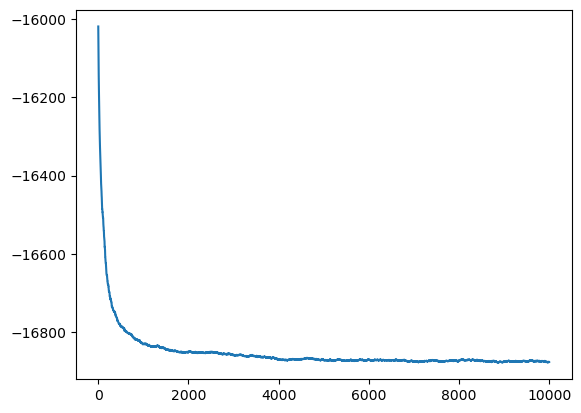

In [27]:
#from smol.moca.analysis.convergence import check_property_converged, determine_discard_number

energies = samples.get_energies()
# 100 as an initial guess for amount to discard
#opt_discard = determine_discard_number(property_array=energies, init_discard=100, verbose=True)
#converged = check_property_converged(energies[opt_discard:])
#print(f'Is the energy converged after discarding the first {opt_discard} samples?', converged)
print(energies)

# let's plot the energy trajectories over time 

import matplotlib.pyplot as plt
runs = np.arange(len(energies))
plt.plot(runs, energies)

### 6) Look at trajectory samples and averages
We can look at the sampled energies, the average and variance directly from the class properties.

For further analysis samples are stored as a list of dictionaries for each sampled step in the `CanonicalEnsemble.data` attribute.
In the `CanonicalEnsemble` class only the energy and occupancy string of each sample are saved.

In [28]:
# Set 100 samples for burn-in, as determined in 5)
discard = 100 # this is in terms of samples so it would be discard*thin_by steps
print(f'A total of {len(samples)} samples taken.')
print(f'A total of {len(samples.get_energies(discard=discard))} samples used for production.')
print(f'The average energy is {samples.mean_energy(discard=discard)} eV')
print(f'The energy variance is {samples.energy_variance(discard=discard)} eV^2')
print(f'The sampling efficiency (acceptance rate) is approximately {samples.sampling_efficiency(discard=discard)}')

A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -16856.99022575071 eV
The energy variance is 1501.4772309798827 eV^2
The sampling efficiency (acceptance rate) is approximately 0.0018121812181218122


In [29]:
#write these to cif files
from pymatgen.io.cif import CifWriter
structure_path = '/Users/myless/Packages/structure_maker/Visualization/Structures'

initial_structure = samples.get_sampled_structures(indices=[0])[0]
print(initial_structure)

# write the initial structure to a CIF file
cif = CifWriter(initial_structure)
total_initial_path = os.path.join(structure_path, 'quad_big_initial_structure.cif')
cif.write_file(total_initial_path)

# print the last structure 
final_structure = samples.get_sampled_structures(indices=[-1])[0]
print(final_structure)

# write the final structure to a CIF file
cif = CifWriter(final_structure)
total_final_path = os.path.join(structure_path, 'quad_big_final_structure.cif')
cif.write_file(total_final_path)


Full Formula (Zr189 Ti107 V1056 Cr188 W188)
Reduced Formula: Zr189Ti107V1056(CrW)188
abc   :  31.280838  31.280838  31.280838
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (1728)
   #  SP           a         b         c
----  ----  --------  --------  --------
   0  V     0         0         0
   1  V     0         0         0.083333
   2  V     0         0         0.166667
   3  V     0         0         0.25
   4  V     0         0         0.333333
   5  Cr    0         0         0.416667
   6  Zr    0         0         0.5
   7  V     0         0         0.583333
   8  V     0         0         0.666667
   9  V     0         0         0.75
  10  V     0         0         0.833333
  11  Zr    0         0         0.916667
  12  V     0         0.083333  0
  13  Zr    0         0.083333  0.083333
  14  V     0         0.083333  0.166667
  15  V     0         0.083333  0.25
  16  V     0         0.083333  0.333333
  17  V     0         0.083333 

### Save your work
The `Sampler` class does and can not be saved since it does not really have any computed values. However the `SampleContainter` where the MC samples are recorded can be saved.
You can use the same `save_work` convenience function to save your work.

You can also save the `SampleContainer` as an hdf5 file. You will need `h5py` installed.